# Pathway Planning

In this example, we demonstrate how PyPSA can deal with optimisation problems spanning multiple investment periods, also known as pathway planning. 

For models with multiple investment periods, the total set of snapshots is divided into investment periods, which translates into multi-indexed snapshots with investment periods as the first level time steps as the second level. In each investment period, new components may be added to the system. Additionally, any component may only operate as long as allowed by their lifetime.

In contrast to the models with a single investment period (overnight scenarios), the following concepts have to be taken into account.:

1. The network attribute `n.investment_periods`: This is the set of periods which specify when new components may be built. These have to be the same as the first level values in the `n.snapshots` index.
2. The network attribute `n.investment_period_weightings`: These specify the weighting of each period in the objective function and the global constraints. 
3. The component attribute `build_year`: Any one component may only be built when the build year is equal to the current investment period, or larger than the previous investment period. That means, components with `build_year=2029` are considered in the investment period `2030`, but not in the period `2025`.  
4. The component attribute `lifetime`: Any one component is only considered for dispatch in an investment period if it is still active at the beginning of an investment period. That means, components with `build_year=2029` and `lifetime=30` are considered in the investment period `2055`, but not in the period `2060`.   

In the following, we set up a three bus network with generators, lines and storage units and run a optimisation for the investment periods 2020, 2030, 2040 and 2050.

In [25]:
import numpy as np
import pandas as pd

import pypsa

rng = np.random.default_rng()  # Create a random number generator

We set up the network with investment periods and snapshots. 

In [26]:
n = pypsa.Network()
years = [2020, 2030, 2040, 2050]
freq = 24

snapshots = pd.DatetimeIndex([])
for year in years:
    period = pd.date_range(
        start=f"{year}-01-01 00:00",
        freq=f"{freq}h",
        periods=8760 // freq,
    )
    snapshots = snapshots.append(period)

# convert to multiindex and assign to network
n.snapshots = pd.MultiIndex.from_arrays([snapshots.year, snapshots])
n.investment_periods = years

n.snapshot_weightings

objective  stores  generators
period timestep                                 
2020   2020-01-01        1.0     1.0         1.0
       2020-01-02        1.0     1.0         1.0
       2020-01-03        1.0     1.0         1.0
       2020-01-04        1.0     1.0         1.0
       2020-01-05        1.0     1.0         1.0
...                      ...     ...         ...
2050   2050-12-27        1.0     1.0         1.0
       2050-12-28        1.0     1.0         1.0
       2050-12-29        1.0     1.0         1.0
       2050-12-30        1.0     1.0         1.0
       2050-12-31        1.0     1.0         1.0

[1460 rows x 3 columns]

In [27]:
n.investment_periods

Index([2020, 2030, 2040, 2050], dtype='int32', name='period')

Set the years and objective weighting per investment period. For the objective weighting, we consider a discount rate defined by 
$$ D(t) = \dfrac{1}{(1+r)^t} $$ 

where $r$ is the discount rate. For each period we sum up all discounts rates of the corresponding years which gives us the effective objective weighting.

In [28]:
n.investment_period_weightings["years"] = list(np.diff(years)) + [10]

r = 0.01
T = 0
for period, nyears in n.investment_period_weightings.years.items():
    discounts = [(1 / (1 + r) ** t) for t in range(T, T + nyears)]
    n.investment_period_weightings.at[period, "objective"] = sum(discounts)
    T += nyears
n.investment_period_weightings

,objective,years
period,,
2020,9.566018,10
2030,8.659991,10
2040,7.839777,10
2050,7.097248,10


Add the components

In [29]:
for i in range(3):
    n.add("Bus", f"bus {i}")

# add three lines in a ring
n.add(
    "Line",
    "line 0->1",
    bus0="bus 0",
    bus1="bus 1",
)

n.add(
    "Line",
    "line 1->2",
    bus0="bus 1",
    bus1="bus 2",
    capital_cost=10,
    build_year=2030,
)

n.add(
    "Line",
    "line 2->0",
    bus0="bus 2",
    bus1="bus 0",
)

n.lines["x"] = 0.0001
n.lines["s_nom_extendable"] = True

n.lines

,bus0,bus1,type,x,r,g,b,s_nom,s_nom_mod,s_nom_extendable,...,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt
Line,,,,,,,,,,,,,,,,,,,,,
line 0->1,bus 0,bus 1,,0.0001,0.0,0.0,0.0,0.0,0.0,True,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
line 1->2,bus 1,bus 2,,0.0001,0.0,0.0,0.0,0.0,0.0,True,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
line 2->0,bus 2,bus 0,,0.0001,0.0,0.0,0.0,0.0,0.0,True,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
# add some generators
p_nom_max = pd.Series(
    (rng.uniform() for sn in range(len(n.snapshots))),
    index=n.snapshots,
    name="generator ext 2020",
)

# renewable (can operate 2020, 2030)
n.add(
    "Generator",
    "generator ext 0 2020",
    bus="bus 0",
    p_nom=50,
    build_year=2020,
    lifetime=20,
    marginal_cost=2,
    capital_cost=1,
    p_max_pu=p_nom_max,
    carrier="solar",
    p_nom_extendable=True,
)

# can operate 2040, 2050
n.add(
    "Generator",
    "generator ext 0 2040",
    bus="bus 0",
    p_nom=50,
    build_year=2040,
    lifetime=11,
    marginal_cost=25,
    capital_cost=10,
    carrier="OCGT",
    p_nom_extendable=True,
)

# can operate in 2040
n.add(
    "Generator",
    "generator fix 1 2040",
    bus="bus 1",
    p_nom=50,
    build_year=2040,
    lifetime=10,
    carrier="CCGT",
    marginal_cost=20,
    capital_cost=1,
)

n.generators

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
generator ext 0 2020,bus 0,PQ,,50.0,0.0,True,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
generator ext 0 2040,bus 0,PQ,,50.0,0.0,True,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
generator fix 1 2040,bus 1,PQ,,50.0,0.0,False,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0


In [31]:
n.add(
    "StorageUnit",
    "storageunit non-cyclic 2030",
    bus="bus 2",
    p_nom=0,
    capital_cost=2,
    build_year=2030,
    lifetime=21,
    cyclic_state_of_charge=False,
    p_nom_extendable=False,
)

n.add(
    "StorageUnit",
    "storageunit periodic 2020",
    bus="bus 2",
    p_nom=0,
    capital_cost=1,
    build_year=2020,
    lifetime=21,
    cyclic_state_of_charge=True,
    cyclic_state_of_charge_per_period=True,
    p_nom_extendable=True,
)

n.storage_units

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,state_of_charge_initial_per_period,state_of_charge_set,cyclic_state_of_charge,cyclic_state_of_charge_per_period,max_hours,efficiency_store,efficiency_dispatch,standing_loss,inflow,p_nom_opt
StorageUnit,,,,,,,,,,,,,,,,,,,,,
storageunit non-cyclic 2030,bus 2,PQ,,0.0,0.0,False,0.0,inf,-1.0,1.0,...,False,NaN,False,True,1.0,1.0,1.0,0.0,0.0,0.0
storageunit periodic 2020,bus 2,PQ,,0.0,0.0,True,0.0,inf,-1.0,1.0,...,False,NaN,True,True,1.0,1.0,1.0,0.0,0.0,0.0


Add the load

In [32]:
load_var = pd.Series(
    100 * rng.random(size=len(n.snapshots)), index=n.snapshots, name="load"
)
n.add("Load", "load 2", bus="bus 2", p_set=load_var)

load_fix = pd.Series(75, index=n.snapshots, name="load")
n.add("Load", "load 1", bus="bus 1", p_set=load_fix)

n.loads_t.p_set.head()

Load               load 1     load 2
period timestep                     
2020   2020-01-01    75.0  38.149498
       2020-01-02    75.0  52.108195
       2020-01-03    75.0  24.336293
       2020-01-04    75.0  66.981352
       2020-01-05    75.0  45.518283

Run the optimization

In [33]:
n.optimize(multi_investment_periods=True, log_to_console=False)

Index(['line 0->1', 'line 1->2', 'line 2->0'], dtype='object', name='Line')
Index(['line 0->1', 'line 1->2', 'line 2->0'], dtype='object', name='Line')
Index(['generator ext 0 2020', 'generator ext 0 2040', 'generator fix 1 2040'], dtype='object', name='Generator')


Index(['bus 0', 'bus 1', 'bus 2'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 9/9 [00:00<00:00, 350.60it/s]
INFO:linopy.io: Writing time: 0.22s


Running HiGHS 1.11.0 (git hash: 364c83a): Copyright (c) 2025 HiGHS under MIT licence terms


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 12417 primals, 32491 duals
Objective: 1.79e+07
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Line-ext-s-lower, Line-ext-s-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, Kirchhoff-Voltage-Law, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

In [ ]:
c = "Generator"
df = pd.concat(
    {
        period: n.get_active_assets(c, period) * n.static(c).p_nom_opt
        for period in n.investment_periods
    },
    axis=1,
)
df.T.plot.bar(
    stacked=True,
    edgecolor="white",
    width=1,
    ylabel="Capacity (MW)",
    xlabel="Investment Period",
    rot=0,
)

<Axes: xlabel='Investment Period', ylabel='Capacity (MW)'>

<Axes: xlabel='Investment Period', ylabel='Generation'>

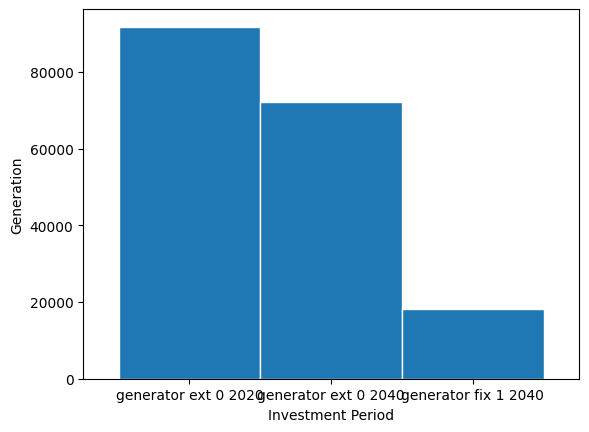

In [ ]:
df = n.generators_t.p.sum(axis=0).T.div(1e3)
df.T.plot.bar(
    stacked=True,
    edgecolor="white",
    width=1,
    ylabel="Generation (GWh)",
    xlabel="Investment Period",
    rot=0,
)